In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import glob
from tqdm import tqdm_notebook, tqdm
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.python.keras.metrics import Metric
import tensorflow as tf

from skimage.io import imread, imshow, concatenate_images
from PIL import Image
import cv2

from albumentations import RandomCrop, HorizontalFlip, VerticalFlip
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
        #pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
# Define paths correctly
path = "/kaggle/input/plastic/micro_plastic_1/"
images_path = sorted(glob.glob(os.path.join(path, "0_train", "*.*")))  # Add wildcard for files
labels_path = sorted(glob.glob(os.path.join(path, "0_train_bi", "*.*")))  # Add wildcard for files


In [12]:
print("Images Path Count:", len(images_path))
print("Labels Path Count:", len(labels_path))

Images Path Count: 1935
Labels Path Count: 1935


In [13]:
# Create save directories properly
save_path = "/kaggle/working/test-case/test/"
image_save_path = os.path.join(save_path, "images")
mask_save_path = os.path.join(save_path, "masks")

In [14]:
os.makedirs(image_save_path, exist_ok=True)
os.makedirs(mask_save_path, exist_ok=True)

In [15]:
def augment_data(images, masks, save_path, augment=False):
    W, H = 1944, 2592  # Image dimensions
    
    for x, y in tqdm(zip(images, masks), total=len(images)):
        image_filename = os.path.basename(x)
        mask_filename = os.path.basename(y)
        
        # Ensure filename contains an extension
        if "." in image_filename and "." in mask_filename:
            image_name, image_extn = image_filename.rsplit(".", 1)
            mask_name, mask_extn = mask_filename.rsplit(".", 1)
        else:
            print(f"Skipping file with no extension: {image_filename} or {mask_filename}")
            continue  # Skip if no extension

        # Read images and resize
        x_img = cv2.imread(x, cv2.IMREAD_COLOR)
        # In augment_data function
        y_img = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

        x_img = cv2.resize(x_img, (W, H))
        y_img = cv2.resize(y_img, (W, H))

        save_images, save_masks = [x_img], [y_img]
        
        if augment:
            augmentations = [
                RandomCrop(int(2 * H / 3), int(2 * W / 3), always_apply=True, p=1.0),
                HorizontalFlip(always_apply=True, p=1.0),
                VerticalFlip(always_apply=True, p=1.0)
            ]

            for aug in augmentations:
                augmented = aug(image=x_img, mask=y_img)
                save_images.append(augmented["image"])
                save_masks.append(augmented["mask"])

        for idx, (img, mask) in enumerate(zip(save_images, save_masks)):
            img_resized = cv2.resize(img, (W, H))
            mask_resized = cv2.resize(mask, (W, H))

            img_path = os.path.join(image_save_path, f"{image_name}_{idx}.{image_extn}")
            mask_path = os.path.join(mask_save_path, f"{mask_name}_{idx}.{mask_extn}")

            cv2.imwrite(img_path, img_resized)
            cv2.imwrite(mask_path, mask_resized)

# Run augmentation
augment_data(images_path, labels_path, save_path, augment=True)


100%|██████████| 1935/1935 [08:11<00:00,  3.94it/s]


In [16]:
# Validate saved images
aug_images = sorted(glob.glob(os.path.join(image_save_path, "*.*")))
aug_masks = sorted(glob.glob(os.path.join(mask_save_path, "*.*")))

print(f"Augmented Images: {len(aug_images)}, Augmented Masks: {len(aug_masks)}")

Augmented Images: 7740, Augmented Masks: 7740


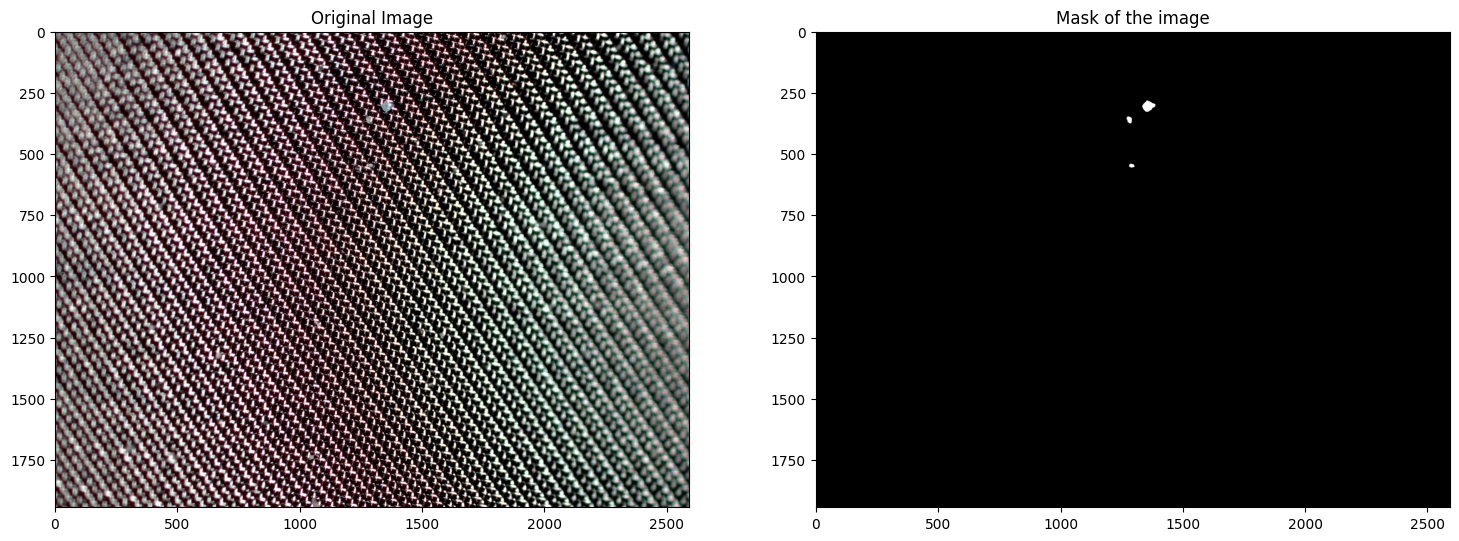

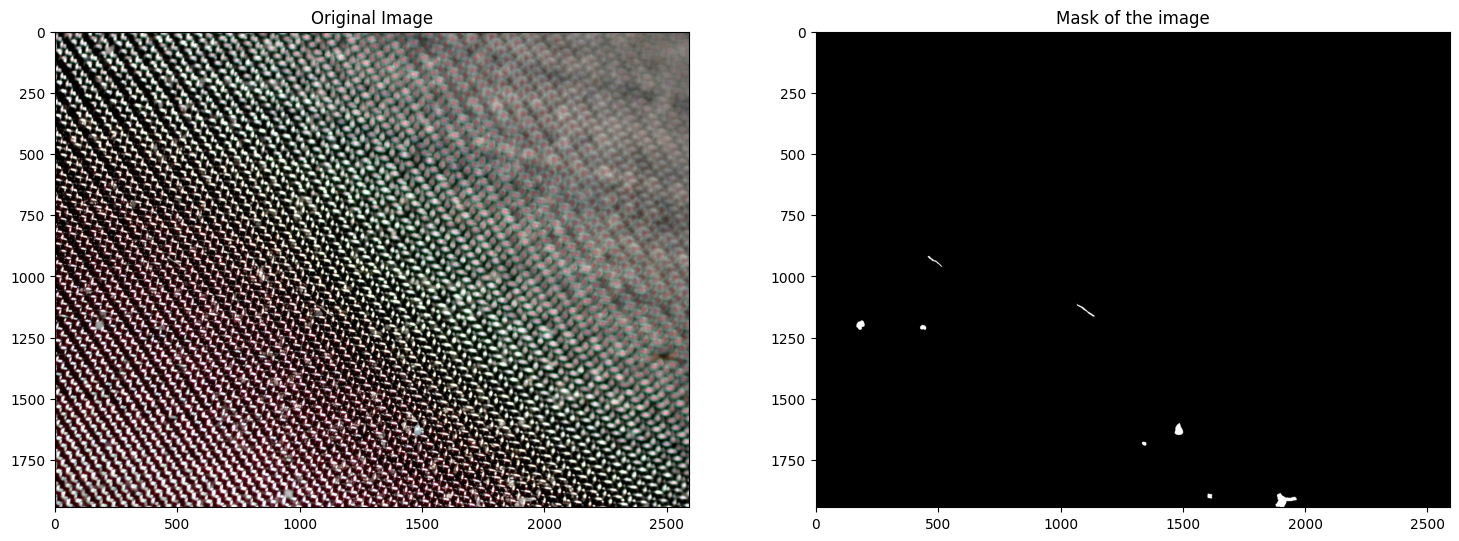

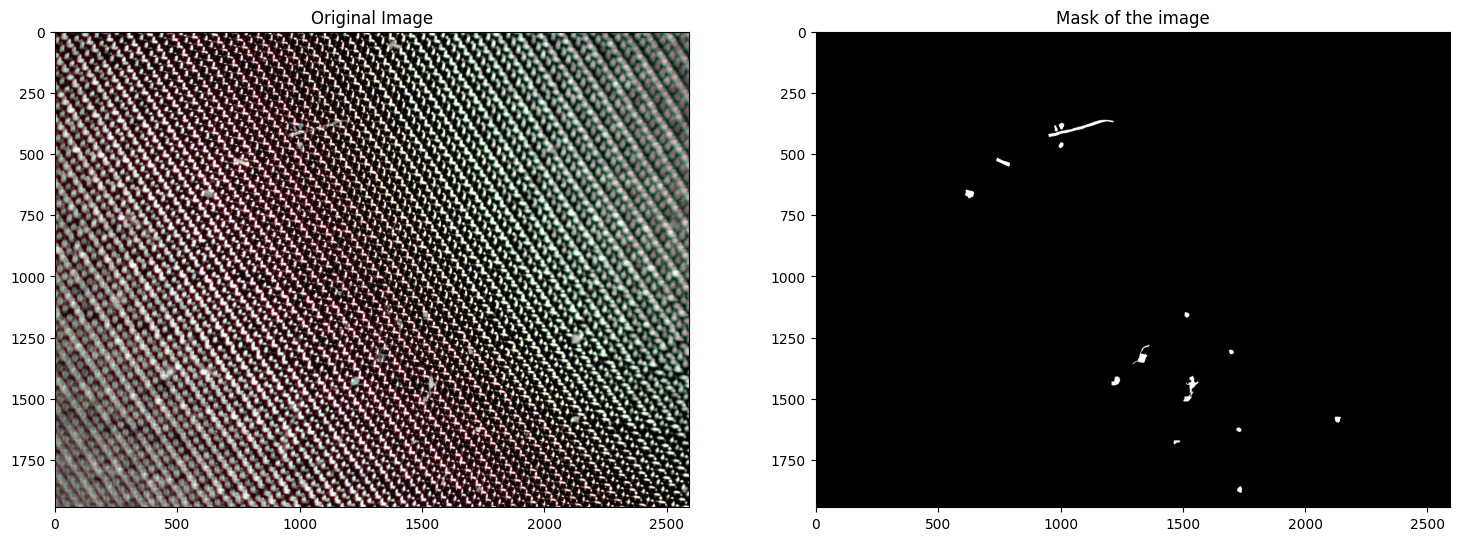

In [17]:
for i in range(0, 3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 12))
    aerial_img = imread(images_path[i])
    #print(aerial_img.shape)
    ax1.imshow(aerial_img)
    ax1.set_title('Original Image')
    
    aerial_mask = imread(labels_path[i])
    ax2.imshow(aerial_mask)
    ax2.set_title('Mask of the image')

In [18]:
to_augment = True  # Set this to True if you want to augment the data, otherwise False

if to_augment:
    image_path = os.path.join(save_path, "images")
    label_path = os.path.join(save_path, "masks")
else:
    image_path = os.path.join(path, "0_train")
    label_path = os.path.join(path, "0_train_bi")


name = list()

for dirname, _, filenames in os.walk(image_path):
    for filename in filenames:
        #print(dirname)
        #print(filename)
        name.append(filename.split('.')[0])

In [19]:
df_images = pd.DataFrame({'id': name}, index = np.arange(0, len(name)))
df_labels = pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [20]:
Xtrainval, Xtest = train_test_split(df_images['id'], test_size = 0.2, random_state = 19)

print(f"Train Size: {len(Xtrainval)} images")
print(f"Test Size: {len(Xtest)} images")

Xtrain, Xval = train_test_split(Xtrainval, test_size=0.2, random_state=19)

print(f"Val Size: {len(Xval)} images")

Train Size: 6192 images
Test Size: 1548 images
Val Size: 1239 images


In [21]:
Ytrain = Xtrain
Ytest = Xtest
Yval = Xval

In [32]:
if to_augment:
    img_train = [os.path.join(save_path, "images", f"{name}.jpg") for name in Xtrain]
    mask_train = [os.path.join(save_path, "masks", f"{name}.jpg") for name in Ytrain]
    
    img_test = [os.path.join(save_path, "images", f"{name}.jpg") for name in Xtest]
    mask_test = [os.path.join(save_path, "masks", f"{name}.jpg") for name in Ytest]
    
    img_val = [os.path.join(save_path, "images", f"{name}.jpg") for name in Xval]
    mask_val = [os.path.join(save_path, "masks", f"{name}.jpg") for name in Yval]
    
else:
    img_train = [os.path.join(path, "0_train", f"{name}.jpg") for name in Xtrain]
    mask_train = [os.path.join(path, "0_train_bi", f"{name}.jpg") for name in Ytrain]
    
    img_test = [os.path.join(path, "0_train", f"{name}.jpg") for name in Xtest]
    mask_test = [os.path.join(path, "0_train_bi", f"{name}.jpg") for name in Ytest]
    
    img_val = [os.path.join(path, "0_train", f"{name}.jpg") for name in Xval]
    mask_val = [os.path.join(path, "0_train_bi", f"{name}.jpg") for name in Yval]

In [33]:
def conv_block(inputs, filter_count, pool=True, batchnorm = True):
    
    #first layer
    x = Conv2D(filter_count, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #second layer
    x = Conv2D(filter_count, 3, padding = 'same', kernel_initializer = 'he_normal')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

In [34]:
def deconv_block(inputs, concat_layer, filter_count, pool = False):
    u = UpSampling2D((2,2), interpolation='bilinear')(inputs)
    c = Concatenate()([u, concat_layer])
    x = conv_block(c, filter_count, pool = pool, batchnorm = True)
    return u, c, x

In [35]:
def make_me_a_unet(shape, num_classes=3):
    
    inputs = Input(shape) # 768 x 1152
    
    # Downsampling side of the UNET i.e. the encoder !
    
    x1, p1 = conv_block(inputs, 32, pool=True, batchnorm=True)
    x2, p2 = conv_block(p1, 64, pool=True, batchnorm=True)
    x3, p3 = conv_block(p2, 96, pool=True, batchnorm=True)
    x4, p4 = conv_block(p3, 128, pool=True, batchnorm=True)
    b = conv_block(p4, 256, pool=False, batchnorm=True)
    
    # Upsampling side of the UNET i.e the decoder !
    
    u1, c1, x5 = deconv_block(b, x4, 128)
    u2, c2, x6 = deconv_block(x5, x3, 96)
    u3, c3, x7 = deconv_block(x6, x2, 64)
    u4, c4, x8 = deconv_block(x7, x1, 32)
    
    # The output layer
    
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8)
    
    #softmax for multiclass classification, num_classes = 23 !
    
    return Model(inputs, output)

In [36]:
#Setting some parameters

H = 768 
W = int(H*(3/2)) 
num_classes = 3

In [37]:
model = make_me_a_unet((H, W, 3), num_classes)

In [38]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 768, 1152, 3)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 768, 1152, 32)  │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 768, 1152, 32)  │            128 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 768, 1152, 32)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 768, 1152, 32)  │          9,248 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 768, 1152, 32)  │            128 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 768, 1152, 32)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 384, 576, 32)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 384, 576, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 384, 576, 64)   │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 384, 576, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 384, 576, 64)   │         36,928 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 384, 576, 64)   │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 384, 576, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 2,387,651 (9.11 MB)

 Trainable params: 2,384,067 (9.09 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [39]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.float32) / 255.0  # Normalize to [0,1]
    return x

In [40]:
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    if x is None:
        print(f"Error: Unable to read mask file {x}")
        return np.zeros((H, W), dtype=np.int32)
    x = cv2.resize(x, (W, H))
    x = (x > 127).astype(np.int32)  # Convert to binary (0, 1)
    return x

In [41]:
def inspect_mask_values(mask_paths):
    for path in mask_paths[:10]:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.int32)  # Apply same threshold
        unique = np.unique(mask)
        print(f"Mask: {path}, Unique Values: {unique}")

In [42]:
print("Sample mask paths:", mask_train[:5])
for path in mask_train[:5]:
    if not os.path.exists(path):
        print(f"File not found: {path}")

Sample mask paths: ['/kaggle/working/test-case/test/masks/01246_2.jpg', '/kaggle/working/test-case/test/masks/00701_3.jpg', '/kaggle/working/test-case/test/masks/00536_2.jpg', '/kaggle/working/test-case/test/masks/01067_2.jpg', '/kaggle/working/test-case/test/masks/01889_1.jpg']


In [43]:
def tf_dataset(x,y, batch=1):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

In [44]:
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.float32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, num_classes])
    return image, mask

In [45]:
# Seeding
np.random.seed(42)
tf.random.set_seed(42)
                 
shape = (H, W, 3) 

# Hyperparameters
lr = 1e-4 # Learning rate of Adam optimizer
batch_size = 4
epochs = 10

In [46]:
print("Sample mask_train paths:", mask_train[:5])
print("Sample mask_val paths:", mask_val[:5])
print("Sample mask_test paths:", mask_test[:5])

Sample mask_train paths: ['/kaggle/working/test-case/test/masks/01246_2.jpg', '/kaggle/working/test-case/test/masks/00701_3.jpg', '/kaggle/working/test-case/test/masks/00536_2.jpg', '/kaggle/working/test-case/test/masks/01067_2.jpg', '/kaggle/working/test-case/test/masks/01889_1.jpg']
Sample mask_val paths: ['/kaggle/working/test-case/test/masks/01132_0.jpg', '/kaggle/working/test-case/test/masks/00701_0.jpg', '/kaggle/working/test-case/test/masks/00014_2.jpg', '/kaggle/working/test-case/test/masks/00333_0.jpg', '/kaggle/working/test-case/test/masks/01364_2.jpg']
Sample mask_test paths: ['/kaggle/working/test-case/test/masks/01680_1.jpg', '/kaggle/working/test-case/test/masks/00441_2.jpg', '/kaggle/working/test-case/test/masks/00553_1.jpg', '/kaggle/working/test-case/test/masks/00142_3.jpg', '/kaggle/working/test-case/test/masks/00613_2.jpg']


In [47]:
def multiclass_dice_loss(y_true, y_pred, smooth=1e-5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.softmax(y_pred, axis=-1)  # For logits, use softmax
    
    # Compute per-class Dice
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)



In [48]:
# Corrected Metric Classes with Vectorized Updates

class MeanIoUMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MeanIoUMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        
        # Flatten the tensors
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        
        # Compute confusion matrix
        confusion = tf.math.confusion_matrix(y_true_flat, y_pred_flat, num_classes=self.num_classes, dtype=tf.float32)
        intersection = tf.linalg.diag_part(confusion)
        union = tf.reduce_sum(confusion, axis=0) + tf.reduce_sum(confusion, axis=1) - intersection
        
        # Compute IoU per class, avoid division by zero
        iou = intersection / (union + tf.keras.backend.epsilon())
        iou = tf.where(tf.math.is_nan(iou), tf.zeros_like(iou), iou)
        mean_iou = tf.reduce_mean(iou)
        
        self.total_iou.assign_add(mean_iou)
        self.count.assign_add(1.0)

    def result(self):
        return self.total_iou / self.count

    def reset_states(self):
        self.total_iou.assign(0.0)
        self.count.assign(0.0)

class PrecisionMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='precision', **kwargs):
        super(PrecisionMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(num_classes,))
        self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(num_classes,))

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        
        # Flatten the tensors
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        
        # Compute confusion matrix
        confusion = tf.math.confusion_matrix(y_true_flat, y_pred_flat, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(confusion)
        fp = tf.reduce_sum(confusion, axis=0) - tp
        
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        return tf.reduce_mean(precision)

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))

class RecallMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='recall', **kwargs):
        super(RecallMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(num_classes,))
        self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(num_classes,))

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        
        # Flatten the tensors
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        
        # Compute confusion matrix
        confusion = tf.math.confusion_matrix(y_true_flat, y_pred_flat, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(confusion)
        fn = tf.reduce_sum(confusion, axis=1) - tp
        
        self.true_positives.assign_add(tp)
        self.false_negatives.assign_add(fn)

    def result(self):
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return tf.reduce_mean(recall)

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='f1_score', **kwargs):
        super(F1ScoreMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(num_classes,))
        self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(num_classes,))
        self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(num_classes,))

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        
        # Flatten the tensors
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        
        # Compute confusion matrix
        confusion = tf.math.confusion_matrix(y_true_flat, y_pred_flat, num_classes=self.num_classes, dtype=tf.float32)
        tp = tf.linalg.diag_part(confusion)
        fp = tf.reduce_sum(confusion, axis=0) - tp
        fn = tf.reduce_sum(confusion, axis=1) - tp
        
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return tf.reduce_mean(f1)

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

In [49]:
import albumentations as A

aug = A.Compose([
    A.RandomResizedCrop(H, W, scale=(0.08, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
], additional_targets={'mask': 'mask'})

# Apply augmentation to both image and mask
def augment(image, mask):
    augmented = aug(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [50]:
def combined_loss(y_true, y_pred, smooth=1e-5):
    # Dice Loss
    dice_loss = multiclass_dice_loss(y_true, y_pred)
    # Cross-Entropy Loss
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return dice_loss + ce_loss

In [51]:
# Hyperparameters
lr = 1e-4
batch_size = 4
epochs = 10
num_classes = 3  # Ensure this is set correctly

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=combined_loss,  # Or use a multi-class dice loss
    metrics=[
        MeanIoUMetric(num_classes=num_classes),
        PrecisionMetric(num_classes=num_classes),
        RecallMetric(num_classes=num_classes),
        F1ScoreMetric(num_classes=num_classes)
    ]
)

In [ ]:
# Create datasets
train_dataset = tf_dataset(img_train, mask_train, batch=batch_size)
val_dataset = tf_dataset(img_val, mask_val, batch=batch_size)

# Define callbacks (optional)
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
   8262/Unknown 9275s 1s/step - f1_score: 0.3917 - loss: 0.8729 - mean_iou: 0.3690 - precision: 0.4079 - recall: 0.3829